In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split


### ДЗ 
- необходимо взять файл boston house-prices datase (sklearn.datasets.load_boston) 
- построить модель регрессии
- дерево решений
- оптимизировать параметры 
- сравнить результаты

#### Загрузим датасет

In [6]:
from sklearn.datasets import load_boston
df = pd.read_csv(load_boston()['filename'],skiprows=1)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Создам функцию построения дерева

#### Задача регрессии будет решаться по следующему критерию информативности H(R):
        L = arg min (1/N)* sum(y_i - y_mean)^2 

In [492]:
# для теста озьму один признак в массив. Далее буду в цикле перебирать все признаки и сравнивать его с целевой переменной
x = np.array(df[['INDUS','MEDV']] )
x = np.sort(x,axis=0)

In [82]:
def get_HR(x,i, order='left'):
    '''
        Функция будет считать критерий информативности (impurity criterion) H(R) 
        по формуле среднеквадратичного отклонения 
        х - массив
        i - количество элементов от начала
        order - с какой стороны считать left or right
    '''
    if order =='left':
        y_mean = sum(x[:,1][:i])/i
        D = sum((x[:,1][:i] - y_mean)**2)/i
    if order =='right':
        i = len(x) - i
        y_mean = sum(x[:,1][i:])/i
        D = sum((x[:,1][i:] - y_mean)**2)/i        
    return D

In [358]:
# тут мы находим точку с максимальным Функционалом качества IG(R). то есть argmax IG(R)
def get_best_IG(x, start =2):
    '''
        Функция находит лучший IG для данного параметра х
        x - массив должен быть вида [х,у]
        start - начинает бить массив х со второго значения
        выдает индекс параметра, максимальное значение IG и t (из формулы x_i < t) 
    '''
    a = np.array([], dtype=float)
    if len(x)< 3: start = 1 
        
    for i in range(start,len(x),1):
        IG = get_HR(x,len(x),order='left') - get_HR(x,i,order='left') - get_HR(x,i,order='right')
        a = np.append(a,IG)
    return np.argmax(a)+start, np.max(a),np.mean(x[:,0][position-1:position+1])

In [435]:
#  проверка функции
get_best_IG(np.array(df))

(39, 513.8269942448977, 0.027299999999999998)

In [445]:
# построение дерева идет по словарю 'conditional_tree'. 
# Начинаем построение по принципу x>t, то есть максимально расширяем ветку дерева у кторого x>t.
# Как только достигнут критерий останова ветки x>t. Переходим на ветку x<t

# структура conditional_tree = {key: ('LSTAT', IG, t, 'количество элементов в выборке', 'значение y_mean')}


def get_the_branch(x_array, conditional_tree_dict,input_key='last', order='right'):
    '''
        Функция считает ветку дерева, то есть ищет такой параметр x, по которому дисперсия целевой переменной максимальна
        записывает результат в словарик conditional tree
        order - с какой стороны идем: 
             * если 'right'(x>t) добавляем к ключу словаря "conditional tree" '.1' 
             * если 'left' (x<t) добавляем к ключу словаря "conditional tree" '.2'        
    '''
    if len(x_array)<3: 
        if order == 'right': return None # останов по размеру выборки
    
    # Тут я получаю результаты IG по всех столбцам в переменную 'l'
    l = np.array([], dtype=float)
    
    for i in range(1,14,1):
        x_i = x_array[:,[i,-1] ]     # берем массив из одного признака 'x_i' и целевой переменной 'у'
        x_i = x_i[x_i[:,0].argsort()]           #сортируем массив по признаку 'x_i' 
        l = np.concatenate(( l,[i],get_best_IG(x_i) ))  #находим максимальный IG

    l = np.reshape(l,(-1,4))

    # Тут я нахожу максимум IG и записываю его значения в список 'result' 
    # 'result' имеет вид: 'номер столбца', 'размер выборки слева', IG, t для условия (x<t)
    result = l[l[:,2].argsort()[-1]]
    if result[2]<0.1: return None #останов по IG<0
    
    # добавляем '.1' если (x>t что означает 'right') и '.2' если (x<t что означает 'left')
    
    if order == 'right': 
        last_conditional_tree_key = str(list(conditional_tree_dict.keys())[-1])
        last_conditional_tree_key +='.1' 
    if order == 'left': 
        last_conditional_tree_key = input_key[:-2]
        last_conditional_tree_key +='.2'
    
    # Новый элемен получит название в словаре '#.1' - который будет соответствовать (x>t)
    # структура conditional_tree = {ключ: ('LSTAT', IG, t, 'количество элементов в выборке', 'значение y_mean')}
    conditional_tree_dict[last_conditional_tree_key] = (  df.columns[result[0].astype(int)], \
                                                   result[2], result[3], len(x_array), np.mean(x_array[:,-1])   )
    
    # распределяю на две выборки 'X_left' и 'X_right' по полученному условию x<t  
    
    x_array = x_array[x_array[:,result[0].astype(int)].argsort()] # сортируем массив X по признаку х, у которого была максимальная IG 
    X_left = x_array[:result[1].astype(int),:]        # берем n элементов слева, n соответствует условию 'размер выборки, для которой x<t'
    X_right = x_array[result[1].astype(int):,:]       # берем n элементов справа, n соответствует условию 'размер выборки, для которой x<t'
    return X_left , X_right, conditional_tree_dict

# начинаю цикл заново. Новый элемен получит название в словаре '1.1' - который будет соответствовать (x>t)
# элемент '1.2' будет соответствовать (x<t) если количество элементов <2 -> то формируется лист leaf

In [304]:
X = np.array(df )
X_left, X_right,conditional_tree = get_the_branch(X,conditional_tree) 

In [446]:
X = np.array(df.loc[:20,:])
conditional_tree = {0:()}
all_X_left = dict()

for i in range(len(X)):
    try:
        X_left, X_right,conditional_tree = get_the_branch(X,conditional_tree)
        #обновляем вершину дерева
        current_top_point = list(conditional_tree.keys())[-1]
        all_X_left[current_top_point] = X_left
        
    except:  # Это означает останов спуска вправо (x>t). Нужно проверять все X_left 
        # Записываем в Х значение X_left в последней вершине 

        
        for i in range(len(all_X_left.keys())):
            new_top_point = list(all_X_left.keys())[-(i+1) ]
            
            try:
                
                X = all_X_left[new_top_point]
            
                X_left, X_right,conditional_tree = get_the_branch(X,conditional_tree,input_key = new_top_point,order='left')
                all_X_left[new_top_point] = X_left
                if conditional_tree[new_top_point][1] - conditional_tree[list(conditional_tree.keys() )[-1] ][1]<.1:break
            except:
                continue
                
#         
    X = X_right
        
# вот так выглядит решающее дерево в моей функции. 
# Ключ ( принцип ключа описал ниже), название признака (отбирающего), IG системыдо среза, значение t для x<t, среднее значение целевой функции
# key, dataframe column, IG, t, y_mean(before slicing)
conditional_tree

{0: (),
 '0.1': ('LSTAT',
  18.117923942721884,
  4.505000000000001,
  21,
  22.414285714285718),
 '0.1.1': ('AGE', 2.94066932351447, 37.8, 19, 21.189473684210526),
 '0.1.1.1': ('LSTAT', 0.3379974189414412, 5.27, 17, 21.135294117647057),
 '0.1.1.2': ('MEDV', 5.522499999999999, 28.7, 2, 26.35),
 '0.1.2': ('MEDV', 2.1025000000000027, 23.1, 2, 21.65),
 '0.2': ('MEDV', 0.42250000000000276, 34.7, 2, 34.05)}

- 0 - стартовая точка - начало дерева
- 0.1 проверка параметра x>t  
- 0.2 проверка параметра x<t 
- и т.д

In [422]:
X.head(1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24.0


In [452]:
del conditional_tree[0]
conditional_tree_keys = conditional_tree.keys()
conditional_tree_keys

dict_keys(['0.1', '0.1.1', '0.1.1.1', '0.1.1.2', '0.1.2', '0.2'])

In [491]:
X = df.loc[:0,:]
for element in range(len(X)):
    key_element = dict()
    #print(X.loc[element,:])
    for key in conditional_tree_keys:
        print('проверяю ключ',key)
        if (key_element.get(element, 0) ==0) or (int(key_element.get(element, 0)[-1])==1 ): # у этого элемента еще нет ключа или ключ растущий (x>t).   
            if int(key[-1]) == 1:
                print('проверяю x>t')
                print('checking ',conditional_tree[key][0],' > ',conditional_tree[key][2]  )
                print('X element ',conditional_tree[key][0],' = ',X.loc[element,conditional_tree[key][0]])
                if X.loc[element,conditional_tree[key][0]] > conditional_tree[key][2]:
                    print('Good achieved ',key,' level')
                    key_element[element] = key #присвоили ключ
                    print('Есть ли выше ключи ',np.array([i for i in conditional_tree_keys if len(i)>len(key)]   ).size != 0  ) #пустой ли массив?
                    if np.array([i for i in conditional_tree_keys if len(i)>len(key)]   ).size != 0:
                        continue
                    else:
                        y = conditional_tree[key][4]
                else: #ключ не прошел
                    key_element[element] = key[:-1]+'2'
                    print('Bad key changed to x<t level. key = ',key_element.get(element, 0),' level')
                #if X.loc[element,conditional_tree[key][0]] > conditional_tree[key][2]:
                        
        else: # у этого элемента уже есть ключ или ключ не растущий
            if int(key[-1]) != 1: # проверим есть ли у текущего ключа окончание на '2' то есть ключ падающий (x<t)
                print('этот ключ падающий',conditional_tree[key][0],' < ', conditional_tree[key][2] )
                if len(key_element.get(element, 0)) == len(key): # проверим совпадает ли длина.
                    print('длина совпадает у = ',conditional_tree[key][4])
                    y = conditional_tree[key][4]  # длина совпала - значит присваиваем значение y из conditional_tree
                else: 
                    continue   #длина ключа не совпадает
            else: 
                continue          
            continue

print('y = ', y)        


проверяю ключ 0.1
проверяю x>t
checking  LSTAT  >  4.505000000000001
X element  LSTAT  =  4.98
Good achieved  0.1  level
Есть ли выше ключи  True
проверяю ключ 0.1.1
проверяю x>t
checking  AGE  >  37.8
X element  AGE  =  65.2
Good achieved  0.1.1  level
Есть ли выше ключи  True
проверяю ключ 0.1.1.1
проверяю x>t
checking  LSTAT  >  5.27
X element  LSTAT  =  4.98
Bad key changed to x<t level. key =  0.1.1.2  level
проверяю ключ 0.1.1.2
этот ключ падающий MEDV  <  28.7
длина совпадает у =  26.35
проверяю ключ 0.1.2
этот ключ падающий MEDV  <  23.1
проверяю ключ 0.2
этот ключ падающий MEDV  <  34.7
y =  26.35


In [482]:
def predict(element, debug = True):    
    key_element = dict()
    #print(X.loc[element,:])
    for key in conditional_tree_keys:
        if debug: print('проверяю ключ',key)
        if (key_element.get(element, 0) ==0) or (int(key_element.get(element, 0)[-1])==1 ): # у этого элемента еще нет ключа или ключ растущий (x>t).   
            if int(key[-1]) == 1:
                if debug: print('проверяю x>t')
                if debug: print('checking ',conditional_tree[key][0],' > ',conditional_tree[key][2]  )
                if debug: print('X element ',conditional_tree[key][0],' = ',X.loc[element,conditional_tree[key][0]])
                if X.loc[element,conditional_tree[key][0]] > conditional_tree[key][2]:
                    if debug: print('Good achieved ',key,' level')
                    key_element[element] = key #присвоили ключ
                    if debug: print('Есть ли выше ключи ',np.array([i for i in conditional_tree_keys if len(i)>len(key)]   ).size != 0  ) #пустой ли массив?
                    if np.array([i for i in conditional_tree_keys if len(i)>len(key)]   ).size != 0:
                        continue
                    else:
                        y = conditional_tree[key][4]
                else: #ключ не прошел
                    key_element[element] = key[:-1]+'2'
                    if debug: print('Bad key changed to x<t level. key = ',key_element.get(element, 0),' level')
                #if X.loc[element,conditional_tree[key][0]] > conditional_tree[key][2]:
                        
        else: # у этого элемента уже есть ключ или ключ не растущий
            if int(key[-1]) != 1: # проверим есть ли у текущего ключа окончание на '2' то есть ключ падающий (x<t)
                if debug: print('этот ключ падающий',conditional_tree[key][0],' < ', conditional_tree[key][2] )
                if len(key_element.get(element, 0)) == len(key): # проверим совпадает ли длина.
                    if debug: print('длина совпадает у = ',conditional_tree[key][4])
                    y = conditional_tree[key][4]  # длина совпала - значит присваиваем значение y из conditional_tree
                else: 
                    continue   #длина ключа не совпадает
            else: 
                continue          
            continue
   
    return y

Это веткор ответов

In [486]:
X = df.loc[:20,:]
Y = np.array([],dtype=float)
for x_i in range(len(X)):
    Y = np.append(Y, predict(x_i,debug=False))
    #break
Y

array([26.35      , 21.13529412, 34.05      , 34.05      , 21.13529412,
       26.35      , 21.13529412, 21.13529412, 21.13529412, 21.13529412,
       21.13529412, 21.13529412, 21.13529412, 21.13529412, 21.13529412,
       21.13529412, 21.65      , 21.13529412, 21.65      , 21.13529412,
       21.13529412])

### Сравним значения полученные новой функцией со значением оригинала.

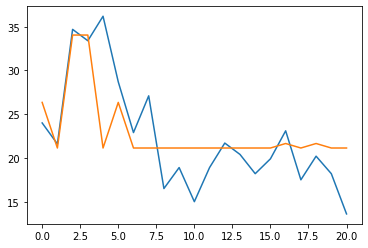

In [488]:
plt.plot(df.loc[:20,'MEDV'])
plt.plot(Y)

Ничего, зато функция своя, усредняется по 3м значениям параметра ( из функции "get_best_IG(x, start =2)") и перебирает все параметры Х при отборе значения целевой преременной

### Теперь применим функцию 'из коробки sklearn'

In [3]:
from sklearn.tree import DecisionTreeRegressor,export_graphviz

In [7]:
reg = DecisionTreeRegressor(criterion='mse',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=3,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.1,
    min_impurity_split=None,
    presort='deprecated',
    ccp_alpha=0.0)

In [8]:
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

In [19]:
def get_score(classifier,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =.33,random_state=255)
    classifier.fit(X_train,y_train)
    return classifier.score(X_train,y_train), classifier.score(X_test,y_test)

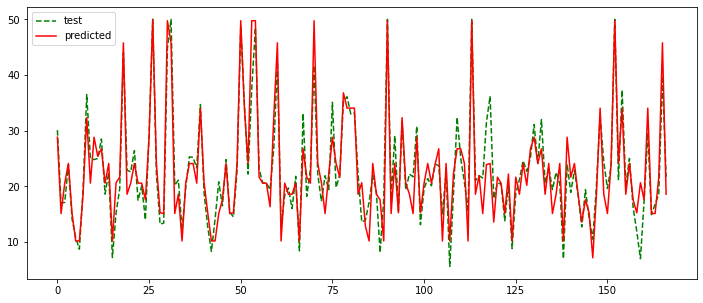

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =.33,random_state=255)
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)
plt.figure(figsize=(12,5))
plt.plot(y_test, 'g--', label='test')
plt.plot(y_pred, 'r-', label='predicted')
plt.legend(loc='best')

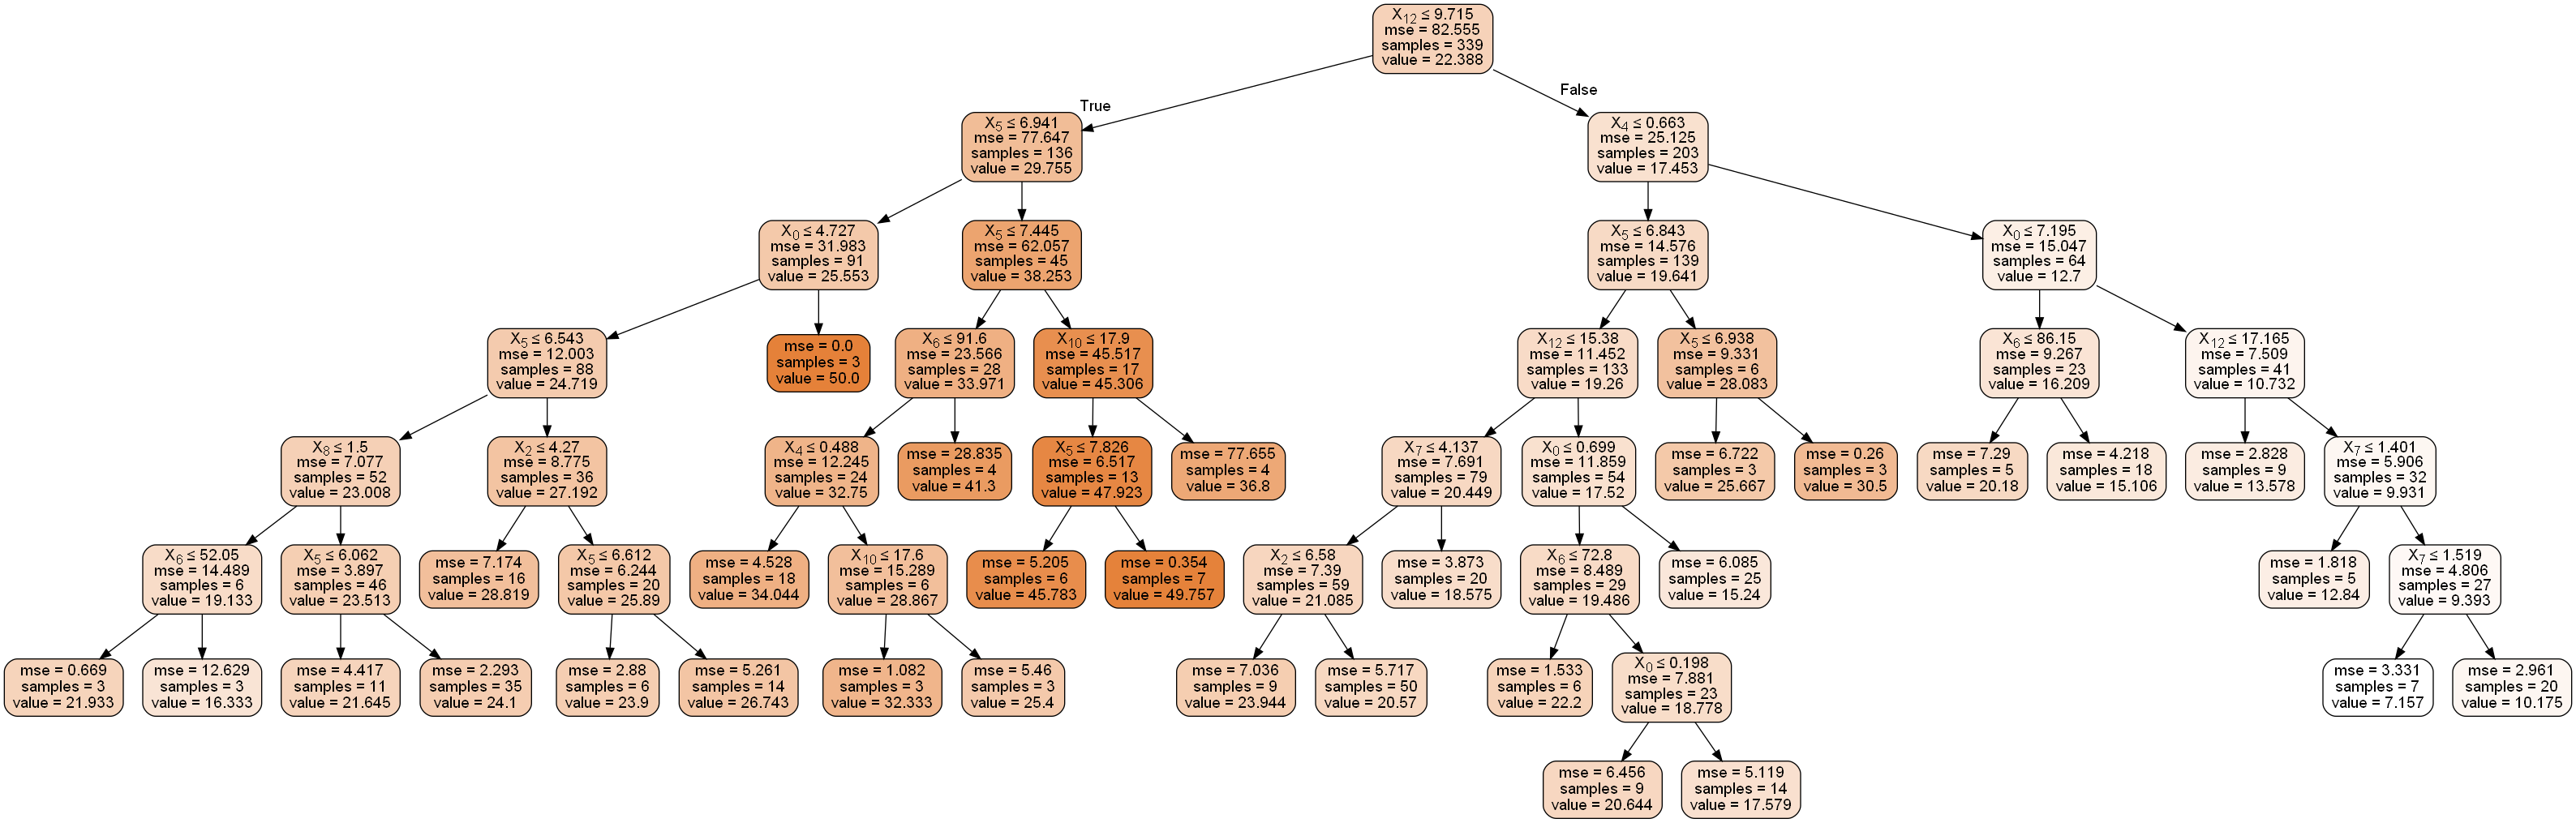

In [21]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(reg, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [23]:
reg.score(X_train,y_train), reg.score(X_test,y_test)

(0.9319886240314044, 0.8534333400425407)

##### Есть мысль, что оптимизируя дерево под reg.score(X_test,y_test) на реальной выборке мы столкнемся с переобучением по тестовой выборке. Для этого будем использовать 2 тестовые выборки - одна для оптимизации, а вторая в самом конце тренировки.

Разобъем на 2 тестовые и прокалибруем результаты построения дерева, на основании метрики, указанной выше (score train и score test)

In [62]:
X_train, X_test_last, y_train, y_test_last = train_test_split(X,y,test_size =.15,random_state=255)
X = X_train
y = y_train

In [72]:
calibration_results = dict()
reg = DecisionTreeRegressor(criterion='mse')
calibration_results['MSE'] = get_score(reg,X,y)

In [74]:
reg = DecisionTreeRegressor(criterion='mae')
calibration_results['MAE'] = get_score(reg,X,y)

In [30]:
import optuna

In [75]:
#Откалибруем параметр max_depth( параметр максимальной глубины дерева)

def objective(trial):
    depth = trial.suggest_int('depth', 1, 100)
    reg = DecisionTreeRegressor(criterion='mse',max_depth = depth )
    
    return get_score(reg,X,y)[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

#!telegram-send optuna_best_{study.best_params['depth']}

reg = DecisionTreeRegressor(criterion='mse',max_depth = study.best_params['depth'] )
calibration_results['depth'] = get_score(reg,X,y)
#'depth': 25

[I 2021-07-17 18:06:54,338] A new study created in memory with name: no-name-fe219ead-a4e2-4ab1-9abc-cb519a93301c
[I 2021-07-17 18:06:54,348] Trial 0 finished with value: 0.7835654152672038 and parameters: {'depth': 88}. Best is trial 0 with value: 0.7835654152672038.
[I 2021-07-17 18:06:54,348] Trial 1 finished with value: 0.7648843607492906 and parameters: {'depth': 56}. Best is trial 0 with value: 0.7835654152672038.
[I 2021-07-17 18:06:54,358] Trial 2 finished with value: 0.7575999100839427 and parameters: {'depth': 91}. Best is trial 0 with value: 0.7835654152672038.
[I 2021-07-17 18:06:54,368] Trial 3 finished with value: 0.770214002566924 and parameters: {'depth': 44}. Best is trial 0 with value: 0.7835654152672038.
[I 2021-07-17 18:06:54,368] Trial 4 finished with value: 0.6971115346518372 and parameters: {'depth': 3}. Best is trial 0 with value: 0.7835654152672038.
[I 2021-07-17 18:06:54,388] Trial 5 finished with value: 0.7854739519613635 and parameters: {'depth': 31}. Best i

[I 2021-07-17 18:06:55,108] Trial 48 finished with value: 0.757863888927173 and parameters: {'depth': 50}. Best is trial 14 with value: 0.8068266544271425.
[I 2021-07-17 18:06:55,128] Trial 49 finished with value: 0.812201051278542 and parameters: {'depth': 25}. Best is trial 49 with value: 0.812201051278542.


In [76]:
#Откалибруем параметр min_samples_leaf ( параметр максимальной глубины дерева)

def objective(trial):
    leaf = trial.suggest_int('leaf', 1, 100)
    reg = DecisionTreeRegressor(criterion='mse', min_samples_leaf  = leaf )
    
    return get_score(reg,X,y)[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

#!telegram-send optuna_best_{study.best_params['leaf']}

reg = DecisionTreeRegressor(criterion='mse', min_samples_leaf = study.best_params['leaf'] )
calibration_results['leaf'] = get_score(reg,X,y)
#'leaf': 1

[I 2021-07-17 18:06:59,849] A new study created in memory with name: no-name-e658a87e-f166-4c85-bbda-0c6f3a87939c
[I 2021-07-17 18:06:59,849] Trial 0 finished with value: 0.669875105299526 and parameters: {'leaf': 30}. Best is trial 0 with value: 0.669875105299526.
[I 2021-07-17 18:06:59,859] Trial 1 finished with value: 0.6367552913929372 and parameters: {'leaf': 46}. Best is trial 0 with value: 0.669875105299526.
[I 2021-07-17 18:06:59,859] Trial 2 finished with value: 0.763433235671418 and parameters: {'leaf': 1}. Best is trial 2 with value: 0.763433235671418.
[I 2021-07-17 18:06:59,869] Trial 3 finished with value: 0.4910882849771512 and parameters: {'leaf': 63}. Best is trial 2 with value: 0.763433235671418.
[I 2021-07-17 18:06:59,879] Trial 4 finished with value: 0.6361556251471109 and parameters: {'leaf': 47}. Best is trial 2 with value: 0.763433235671418.
[I 2021-07-17 18:06:59,879] Trial 5 finished with value: 0.4910882849771512 and parameters: {'leaf': 73}. Best is trial 2 wi

[I 2021-07-17 18:07:00,519] Trial 49 finished with value: 0.6415342565334579 and parameters: {'leaf': 18}. Best is trial 39 with value: 0.8110230077626319.


In [77]:
#Откалибруем параметр ccp_alpha ( параметр стрижки, чем меньше ccp_alpha - тем дороже дерево и переобученнее.)

def objective(trial):
    alpha = trial.suggest_uniform('alpha', 0, 10)
    reg = DecisionTreeRegressor(criterion='mse', ccp_alpha   = alpha )
    
    return get_score(reg,X,y)[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

reg = DecisionTreeRegressor(criterion='mse', ccp_alpha = study.best_params['alpha'] )
calibration_results['ccp_alpha'] = get_score(reg,X,y)
#'alpha': 0.0536089172580039

[I 2021-07-17 18:13:12,842] A new study created in memory with name: no-name-857d3724-8c37-48fa-b026-209e31b6c7f8
[I 2021-07-17 18:13:12,852] Trial 0 finished with value: 0.542654276743767 and parameters: {'alpha': 7.876021818150384}. Best is trial 0 with value: 0.542654276743767.
[I 2021-07-17 18:13:12,862] Trial 1 finished with value: 0.5426542767437668 and parameters: {'alpha': 5.696463312535815}. Best is trial 0 with value: 0.542654276743767.
[I 2021-07-17 18:13:12,872] Trial 2 finished with value: 0.5426542767437668 and parameters: {'alpha': 7.404873868581521}. Best is trial 0 with value: 0.542654276743767.
[I 2021-07-17 18:13:12,892] Trial 3 finished with value: 0.7407170235389762 and parameters: {'alpha': 0.8751032649527013}. Best is trial 3 with value: 0.7407170235389762.
[I 2021-07-17 18:13:12,902] Trial 4 finished with value: 0.5426542767437669 and parameters: {'alpha': 6.781165828026355}. Best is trial 3 with value: 0.7407170235389762.
[I 2021-07-17 18:13:12,912] Trial 5 fin

[I 2021-07-17 18:13:13,633] Trial 44 finished with value: 0.7780822486329867 and parameters: {'alpha': 0.04068017191814391}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:13,653] Trial 45 finished with value: 0.7229560694061098 and parameters: {'alpha': 1.4688978214040564}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:13,673] Trial 46 finished with value: 0.7332317913508242 and parameters: {'alpha': 0.46379833530957376}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:13,693] Trial 47 finished with value: 0.7232996831347214 and parameters: {'alpha': 1.0315918481212134}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:13,703] Trial 48 finished with value: 0.7229560694061098 and parameters: {'alpha': 1.8315383423294875}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:13,723] Trial 49 finished with value: 0.7547014084794521 and parameters: {'alpha': 0.32075877986450946}. Best is 

[I 2021-07-17 18:13:14,435] Trial 88 finished with value: 0.773002349878117 and parameters: {'alpha': 0.005212383820094563}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:14,455] Trial 89 finished with value: 0.7332317913508242 and parameters: {'alpha': 0.45587225458928776}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:14,465] Trial 90 finished with value: 0.7407170235389762 and parameters: {'alpha': 0.8925780685372704}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:14,485] Trial 91 finished with value: 0.796057496986177 and parameters: {'alpha': 0.15987849908273782}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:14,495] Trial 92 finished with value: 0.7905404374230307 and parameters: {'alpha': 0.19819076042664707}. Best is trial 20 with value: 0.8193332402214479.
[I 2021-07-17 18:13:14,505] Trial 93 finished with value: 0.7964935657692873 and parameters: {'alpha': 0.6532754799137213}. Best is 

### Построим графики всех тестов:

In [78]:
calibration_results

{'MSE': (1.0, 0.771260056661219),
 'MAE': (1.0, 0.668844609646681),
 'depth': (1.0, 0.7570469199209688),
 'leaf': (1.0, 0.7515337066089051),
 'ccp_alpha': (0.9779187200403351, 0.7718639603123839)}

Text(0, 0.5, 'test results')

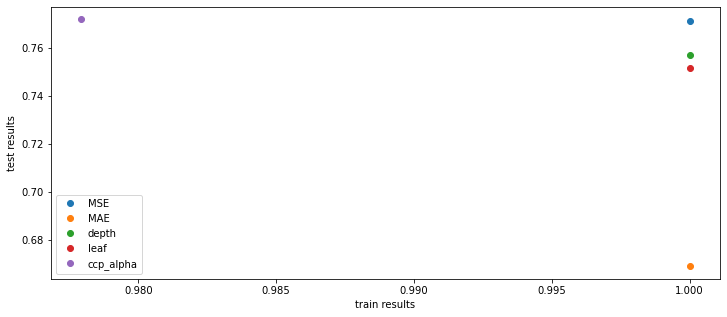

In [89]:
plt.figure(figsize=(12,5))
for key,data in calibration_results.items():
    plt.plot(data[0],data[1],'o',label=key)
    
plt.legend(loc='best')
plt.xlabel('train results')
plt.ylabel('test results')

Самый лучший результат показывает 'MSE'.  
Попробуем его прогнать на втрой тестовой выборке.

In [90]:
reg = DecisionTreeRegressor(criterion='mse')
reg.fit(X,y)
reg.score(X_test,y_test)

0.9421798929774424

Проверим второе по качеству на тестовой выборке дерево "ccp_alpha" 

In [91]:
alpha=0.0536089172580039
reg = DecisionTreeRegressor(criterion='mse', ccp_alpha   = alpha )
reg.fit(X,y)
reg.score(X_test,y_test)

0.9281278712742533

## Вывод :
- Мы собрали дерево сами и протестили его
- мы собрали дерево с максимальной детализацие и построили его структуру
- мы оптимизировали дерево на всех возможных параметрах
- мы дробили на 2 тестовые выборки (одну чтобы постоянно тестироваться и одну в самом конце протестироваться) и полученный результат показал, что лучший образец на показавший лучшие результаты на первой тестовой выборке показал тоже самые лучшие результаты на финальной выборке